In [19]:
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from preprocess import cargar_y_preprocesar_datos
from utils import print_score 

In [12]:
ruta = "./data/credit_card_fraud_dataset.csv"
X_train, X_val, X_test, y_train, y_val, y_test = cargar_y_preprocesar_datos(ruta)

In [15]:
print(f"Tamaño de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño de X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Número de fraudes en y_train: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"Número de fraudes en y_val: {y_val.sum()} ({y_val.sum()/len(y_val)*100:.2f}%)")

Tamaño de X_train: (60000, 15), y_train: (60000,)
Tamaño de X_val: (20000, 15), y_val: (20000,)
Número de fraudes en y_train: 600 (1.00%)
Número de fraudes en y_val: 200 (1.00%)


In [16]:
# Calcular scale_pos_weight para el set de entrenamiento ORIGINAL
# Este parámetro es crucial en XGBoost para manejar el desbalance.
# Se recomienda usarlo incluso si también usas SMOTE, ya que SMOTE crea ejemplos sintéticos,
# pero scale_pos_weight ajusta los pesos de las clases para las muestras reales durante el entrenamiento.
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
initial_scale_pos_weight = neg_count / pos_count
print(f"scale_pos_weight inicial calculado: {initial_scale_pos_weight:.2f}")

# Definimos el pipeline
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)), # Aplicamos SMOTE para generar muestras sintéticas de la clase minoritaria
    ('xgb', xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',       # Métrica de evaluación para el entrenamiento interno de XGBoost
        use_label_encoder=False,     # Para evitar un warning futuro
        # Podemos incluir scale_pos_weight aquí, o tunearlo en el grid de RandomizedSearchCV
        # Si SMOTE está en el pipeline y se ejecuta antes, el ratio de clases para XGBoost ya está balanceado.
        # Por simplicidad, podemos dejar que SMOTE maneje la proporción o ajustar ligeramente el peso.
        # Por ahora, no lo pondremos aquí para que lo tunee RandomizedSearchCV.
    ))
])

scale_pos_weight inicial calculado: 99.00


##### Ajuste de hiperpárametros

In [17]:
param_distributions_xgb = {
    'xgb__n_estimators': [100, 200, 300, 400], # Número de árboles
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2], # Tasa de aprendizaje
    'xgb__max_depth': [3, 5, 7, 9], # Profundidad máxima de cada árbol
    'xgb__subsample': [0.6, 0.8, 1.0], # Submuestreo de filas antes de construir cada árbol
    'xgb__colsample_bytree': [0.6, 0.8, 1.0], # Submuestreo de columnas antes de construir cada árbol
    'xgb__gamma': [0, 0.1, 0.2], # Mínima pérdida de reducción para hacer una partición
    'xgb__lambda': [1, 2], # Regularización L2
    'xgb__alpha': [0, 0.1], # Regularización L1
    # 'xgb__scale_pos_weight': [1, initial_scale_pos_weight, initial_scale_pos_weight * 0.5, initial_scale_pos_weight * 2],
    # Si SMOTE ya está en el pipeline, scale_pos_weight no es tan crítico o podría ser 1.
    # Si quieres que XGBoost maneje el desbalance, quitar SMOTE del pipeline y tunear solo scale_pos_weight.
    # Por ahora, dejemos SMOTE en el pipeline y no tuneemos scale_pos_weight explícitamente en el grid si SMOTE está.
    # Si pruebas sin SMOTE en el pipeline, entonces es CRÍTICO tunear scale_pos_weight.

    # También puedes tunear el sampling_strategy de SMOTE si quieres
    'smote__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1.0] # Proporción de la clase minoritaria después de SMOTE
}

# Define la métrica de scoring. Para fraude, F1-score o Recall de la clase 1 son las más importantes.
# Usaremos F1-score para la clase 1 (fraude)
scorer = make_scorer(f1_score, pos_label=1)

random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_distributions_xgb,
    n_iter=50, # Número de combinaciones a probar. Ajusta según tu tiempo y capacidad de cómputo. Más es mejor.
    cv=3,       # Folds de validación cruzada. 3 o 5 son comunes.
    scoring=scorer,
    random_state=42,
    n_jobs=-1,  # Usa todos los núcleos de CPU disponibles para acelerar el proceso
    verbose=2   # Para ver el progreso detallado
)

print("Iniciando RandomizedSearchCV para XGBoost...")
# Entrenamos el RandomizedSearchCV. ¡Esto puede tomar tiempo!
random_search_xgb.fit(X_train, y_train)

print("\n--- Resultados de RandomizedSearchCV ---")
print(f"Mejor F1-score de validación cruzada: {random_search_xgb.best_score_:.4f}")
print(f"Mejores parámetros encontrados: {random_search_xgb.best_params_}")

# El mejor modelo entrenado
best_xgb_model = random_search_xgb.best_estimator_

Iniciando RandomizedSearchCV para XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:14:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados de RandomizedSearchCV ---
Mejor F1-score de validación cruzada: 0.0203
Mejores parámetros encontrados: {'xgb__subsample': 0.8, 'xgb__n_estimators': 200, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'xgb__lambda': 2, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.8, 'xgb__alpha': 0, 'smote__sampling_strategy': 1.0}


Evaluación Final del Modelo XGBoost y Ajuste del Umbral


--- Umbral de Decisión Optimizado ---
Mejor F1-score en validación (con umbral optimizado): 0.0245
Umbral óptimo para F1-score: 0.4427

--- Evaluación Final de XGBoost en Validación (con Umbral Ajustado) ---
Matriz de Confusión:
[[17101  2699]
 [  164    36]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     19800
           1       0.01      0.18      0.02       200

    accuracy                           0.86     20000
   macro avg       0.50      0.52      0.47     20000
weighted avg       0.98      0.86      0.91     20000

ROC AUC Score: 0.4871


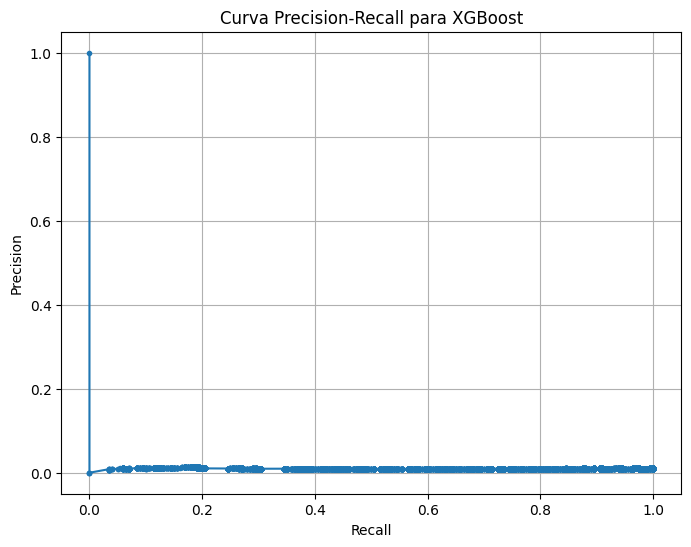

In [ ]:
y_scores_xgb = best_xgb_model.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores_xgb)

# 3. Encontrar el umbral óptimo
# Aquí puedes decidir qué priorizar:
# a) Maximizar F1-score (equilibrio)
# b) Maximizar Recall (detectar más fraudes, a riesgo de más FPs)
# c) Un F-beta score específico (ej. F2-score si Recall es el doble de importante que Precision)

best_f1_val = 0
optimal_threshold = 0.5 

for i in range(len(thresholds)):
    if (precisions[i] + recalls[i]) == 0:
        continue
    current_f1 = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
    if current_f1 > best_f1_val:
        best_f1_val = current_f1
        optimal_threshold = thresholds[i]

print(f"\n--- Umbral de Decisión Optimizado ---")
print(f"Mejor F1-score en validación (con umbral optimizado): {best_f1_val:.4f}")
print(f"Umbral óptimo para F1-score: {optimal_threshold:.4f}")

y_pred_xgb_optimized = (y_scores_xgb >= optimal_threshold).astype(int)

print("\n--- Evaluación Final de XGBoost en Validación (con Umbral Ajustado) ---")
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred_xgb_optimized))
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_pred_xgb_optimized))

roc_auc = roc_auc_score(y_val, y_scores_xgb)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.title('Curva Precision-Recall para XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()